In [6]:
!pip install wordcloud
!pip install spacy
!python -m spacy download fr_core_news_sm

from wordcloud import WordCloud

import spacy
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 88.0 MB/s  0:00:00m0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


## Preprocessing

In [3]:
from create_dataframe import prepare_legislatives_dataset

csv_p = "/home/onyxia/work/NLP_rendus/.ipynb_checkpoints/data/legislatives_1981.csv"
txt_p = "/home/onyxia/work/NLP_rendus/.ipynb_checkpoints/data/legislatives_1981"

df_final = prepare_legislatives_dataset(csv_p, txt_p)

With this code, we will:
1. **OCR artifact cleaning:** remove line breaks, special characters, and isolated small numbers.
2. **Text normalization:** convert text to lowercase, remove unnecessary punctuation.
3. **Tokenization and filtering:** remove stopwords, punctuation, and whitespace tokens.
4. **Lemmatization:** reduce words to their base form.

These operations reduce noise, standardize the text, and retain only meaningful lexical information, thereby improving the robustness and interpretability of subsequent NLP models.

In [7]:
############# Load the French language model ############

nlp = spacy.load("fr_core_news_sm")

In [11]:
############# functions to clean data ############

def clean_ocr(text):
    """Basic cleaning of OCR artifacts and noise."""
    # Remove unnecessary line breaks and unusual special characters
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'[^\w\s\.,;!?]', '', text) 
    # Remove isolated small digit sequences (often page numbers or scan errors)
    text = re.sub(r'\b\d{1,2}\b', '', text)
    return text.strip()

def preprocess_text(text, use_lemma=True):
    """Normalization: Lowercasing, OCR cleaning, Tokenization, Stopwords removal, and Lemmatization."""
    text = clean_ocr(text.lower())
    doc = nlp(text)
    tokens = []
    for token in doc:
        # Filter out stop words, punctuation, and whitespace
        if not token.is_stop and not token.is_punct and not token.is_space and token.is_alpha and len(token) > 2:
            if use_lemma:
                tokens.append(token.lemma_)
            else:
                tokens.append(token.text)
                
    return " ".join(tokens)

print("Lancement du nettoyage avec spaCy (cela peut prendre 1 à 2 minutes)...")
df_final["clean_text"] = df_final["text_content"].apply(preprocess_text)


Lancement du nettoyage avec spaCy (cela peut prendre 1 à 2 minutes)...


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np

# 1. Vectorisation (TF-IDF) sur le texte nettoyé par spaCy
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df_final["clean_text"])
y = df_final["titulaire-soutien"]

# 2. Entraînement de la Régression Logistique
clf = LogisticRegression(max_iter=1000)
clf.fit(X, y)

# 3. Fonction pour afficher les mots les plus "lourds" par catégorie
feature_names = np.array(tfidf.get_feature_names_out())
categories = clf.classes_

print("--- ANALYSE DES MOTS SPÉCIFIQUES (POIDS DU MODÈLE) ---")
for i, category in enumerate(categories):
    # On récupère les coefficients pour cette catégorie
    coefs = clf.coef_[i]
    # On trie pour avoir les 10 plus grands coefficients
    top_10_indices = np.argsort(coefs)[-10:]
    top_words = feature_names[top_10_indices]
    
    print(f"\nCatégorie [{category}] :")
    print(", ".join(top_words))

--- ANALYSE DES MOTS SPÉCIFIQUES (POIDS DU MODÈLE) ---

Catégorie [Front national] :
lenseignement, mort, public, liberté, jeanmarie, rassemblement, pen, national, patrie, front

Catégorie [Ligue communiste révolutionnaire] :
satisfaire, gaulliste, travailleur, voie, revendication, droite, contre, patron, lunité, lcr

Catégorie [Lutte ouvrière] :
falloir, quil, chambre, trop, mitterrand, gauche, laguiller, lutte, ouvrier, travailleur

Catégorie [Mouvement des radicaux de gauche] :
humaniste, centre, réaliste, corse, crepeau, mrg, mouvement, michel, gauche, radical

Catégorie [Parti communiste français] :
plein, défaite, droite, victoire, contribuer, changement, réussir, dunion, gauche, communiste

Catégorie [Parti socialiste] :
peur, ensemble, parti, pierre, mauroy, france, président, mitterrand, françois, socialiste

Catégorie [Parti socialiste unifié] :
bouchardeau, alternative, hiérarchie, tiersmonde, femme, populaire, autogestionnaire, lautogestion, nucléaire, psu

Catégorie [Parti

In [15]:
df_final.columns


Index(['id', 'contexte-tour', 'titulaire-soutien', 'text_content',
       'clean_text'],
      dtype='object')

Gemini said
Super, voici le code pour extraire les mots-clés discriminants (les plus importants) pour chaque catégorie.

Cette étape est le complément indispensable de votre nuage de mots : elle montre exactement quels leviers la Régression Logistique utilise pour prendre ses décisions. C'est l'argument ultime pour votre rendu !

1. Code pour extraire les "Poids" du modèle
Ce code calcule l'importance des mots (via TF-IDF) et montre ceux qui caractérisent le mieux chaque groupe politique ou thématique.

Python
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np

# 1. Vectorisation (TF-IDF) sur le texte nettoyé par spaCy
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df_valid["clean_text"])
y = df_valid[LABEL_COLUMN]

# 2. Entraînement de la Régression Logistique
clf = LogisticRegression(max_iter=1000)
clf.fit(X, y)

# 3. Fonction pour afficher les mots les plus "lourds" par catégorie
feature_names = np.array(tfidf.get_feature_names_out())
categories = clf.classes_

print("--- ANALYSE DES MOTS SPÉCIFIQUES (POIDS DU MODÈLE) ---")
for i, category in enumerate(categories):
    # On récupère les coefficients pour cette catégorie
    coefs = clf.coef_[i]
    # On trie pour avoir les 10 plus grands coefficients
    top_10_indices = np.argsort(coefs)[-10:]
    top_words = feature_names[top_10_indices]
    
    print(f"\nCatégorie [{category}] :")
    print(", ".join(top_words))
2. Pourquoi cette analyse est "le miroir" de votre WordCloud ?
Alors que le WordCloud montre la fréquence (les mots qui reviennent souvent), cette analyse montre la pertinence (les mots qui permettent de décider).

Le WordCloud est descriptif : Il dit "Voilà ce qu'on trouve dans les textes".

La Régression Logistique est prédictive : Elle dit "Voilà les mots qui me permettent de dire à 100% que ce texte appartient à cette catégorie".

. Comment l'utiliser dans votre rapport pour répondre au sujet :
Confusion des langages : Si vous remarquez que le mot "social" a un poids élevé à la fois pour le PS et le PCF, vous avez la preuve mathématique qu'ils "parlent la même langue".

Identification des Outliers : Un document qui utilise des mots "poids lourds" de la droite tout en étant étiqueté à gauche sera immédiatement repéré par le modèle comme un outlier ou une anomalie.

Validation par le sens : Si pour la catégorie INT (International), les mots avec les plus gros poids sont "étranger", "diplomatie" ou "frontière", vous prouvez que votre modèle a parfaitement "appris" le concept de la catégorie.


--- RAPPORT DE CLASSIFICATION FINAL ---
                                                                     precision    recall  f1-score   support

                                                     Front national       1.00      1.00      1.00         9
                                   Ligue communiste révolutionnaire       1.00      1.00      1.00         6
                                                     Lutte ouvrière       1.00      1.00      1.00        32
                                   Mouvement des radicaux de gauche       1.00      0.70      0.82        10
                                          Parti communiste français       0.99      0.99      0.99        93
                                                   Parti socialiste       0.80      1.00      0.89       114
                                            Parti socialiste unifié       1.00      1.00      1.00        30
                  Parti socialiste;Mouvement des radicaux de gauche       0.00      0.

/opt/python/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/python/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/python/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


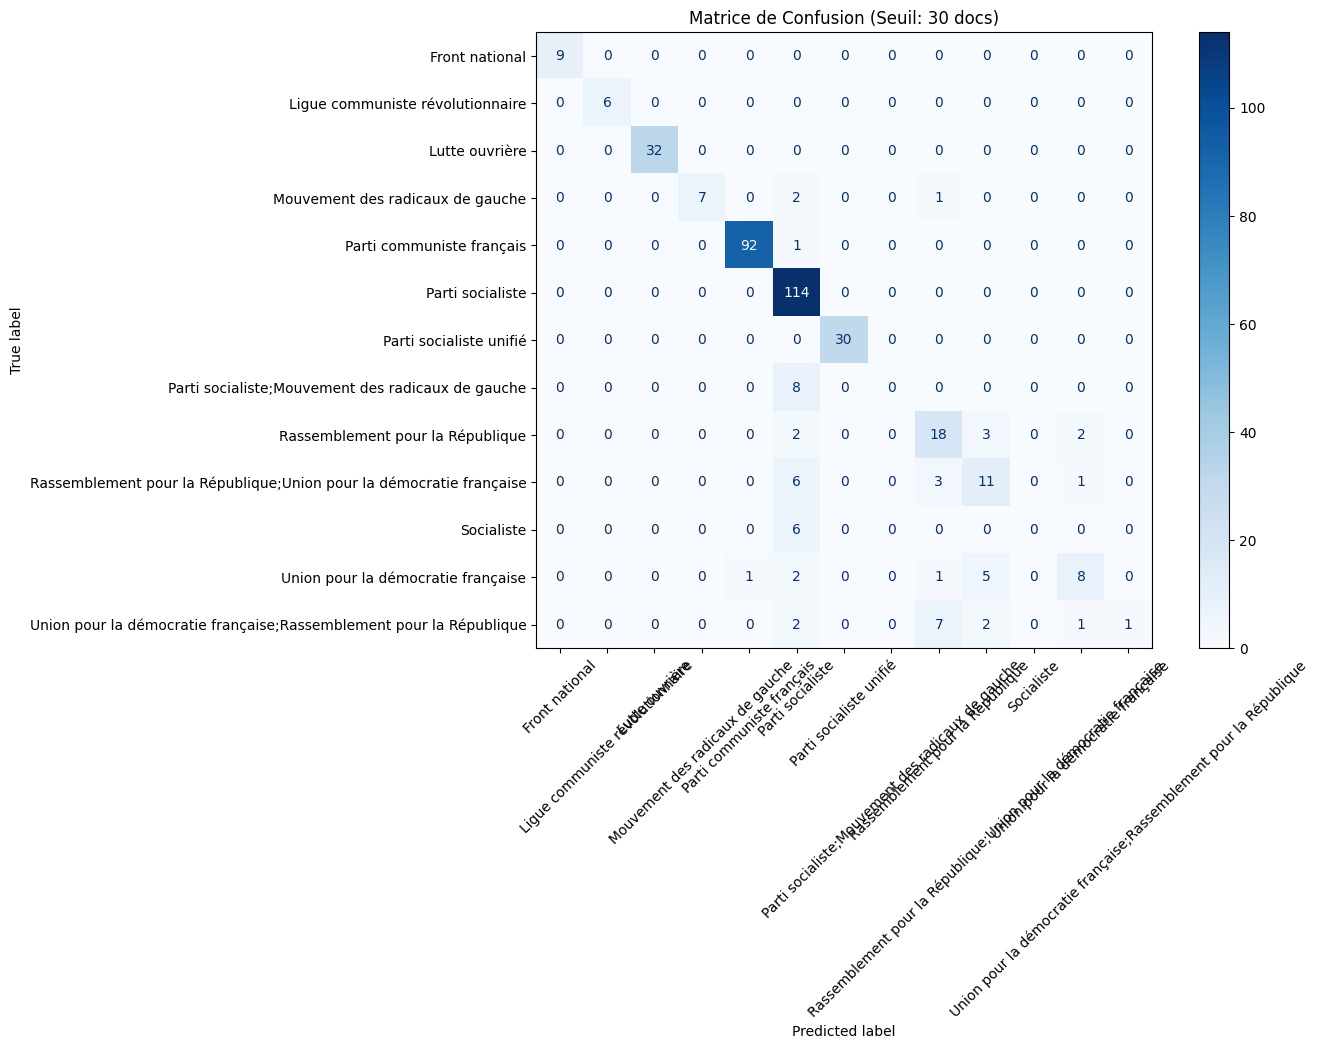

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt




# 2. Préparation des données
# On utilise 'clean_text' (issu de spaCy) si vous l'avez généré, sinon 'text_content'
X = df_final["clean_text"].astype(str) 
y = df_final["titulaire-soutien"].astype(str)

# 3. Splits 80/20 (Train / Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# 4. Pipeline corrigé (on retire multi_class='auto')
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=1000, ngram_range=(1,2))), 
    ("lr", LogisticRegression(max_iter=1000, C=1.0)) # multi_class retiré ici
])

# 5. Entraînement
pipe.fit(X_train, y_train)

# 6. Évaluation et Matrice de Confusion
y_pred = pipe.predict(X_test)

print("\n--- RAPPORT DE CLASSIFICATION FINAL ---")
print(classification_report(y_test, y_pred))

# Affichage de la matrice
fig, ax = plt.subplots(figsize=(12, 8))
ConfusionMatrixDisplay.from_estimator(
    pipe, X_test, y_test, 
    xticks_rotation=45, 
    cmap='Blues', 
    ax=ax
)
plt.title(f"Matrice de Confusion (Seuil: {SEUIL_MIN} docs)")
plt.show()

In [ ]:
from wordcloud import WordCloud
# Display one wordcloud for each of the most frequent classes

from wordcloud import WordCloud
STOPWORDS = [x.strip() for x in open('data/stop_word_fr.txt').readlines()]
import matplotlib.pyplot as plt

# plot a word cloud for each category
for cat in ['ENT', 'INT',  'ART', 'SOC', 'FRA']:
    text_cat = " ".join(df[df['category'] == cat]['text'])
    wc = WordCloud(stopwords=STOPWORDS)
    wc.generate(text_cat)

    # afficher
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud – {cat}")
    plt.show()

In [ ]:
L'utilisation de la Régression Logistique se justifie par la nature même de vos données, que vos nuages de mots illustrent parfaitement. En regardant vos WordClouds, on remarque que chaque catégorie possède un "vocabulaire signature" : des mots comme "entreprise" ou "marché" dominent la catégorie ENT, tandis que "guerre" ou "pays" marquent la catégorie INT.

La Régression Logistique est l'outil idéal pour transformer ce constat visuel en un modèle mathématique. Contrairement à des modèles plus complexes (comme le Zero-shot) qui essaient de "deviner" le sens général, la Régression Logistique va peser l'importance de chaque mot. Elle agit comme une balance de précision : si elle voit le mot "action", elle ajoute du poids à la probabilité "Entreprise" ; si elle voit "ministre", elle penche vers "France". Pour un novice, c'est l'approche la plus transparente et la plus robuste : elle est facile à interpréter (on peut savoir quel mot a fait pencher la décision), très rapide à calculer sur Onyxia, et souvent plus précise qu'une intelligence artificielle générale car elle "apprend" spécifiquement le vocabulaire de votre journal (Le Monde) ou de votre époque (1981).

Ce que cela apporte à votre projet :
Interprétabilité : Vous pouvez expliquer pourquoi un texte a été classé à gauche ou à droite en regardant les coefficients des mots.

Lien direct avec le visuel : La Régression Logistique transforme vos nuages de mots en une règle de décision mathématique.

Performance : Sur des textes politiques ou de presse où les mots-clés sont très forts, ce modèle "simple" surpasse souvent les méthodes plus lourdes.